<a href="https://colab.research.google.com/github/pandapear557/test_for_DNA/blob/main/%EC%B5%9C%EC%A2%85_%EB%8C%80%ED%9A%8C_36_88174%EC%9D%98_%EC%82%AC%EB%B3%B8%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My Drive/4th comp

/content/gdrive/My Drive/4th comp


In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [5]:
train['datetime']=pd.to_datetime(train['datetime'])
test['datetime']=pd.to_datetime(test['datetime'])

In [6]:
train['datetime'].iloc[0]

Timestamp('2017-04-01 00:00:00')

In [7]:
train['hour']= train['datetime'].dt.hour
train['weekday']=train['datetime'].dt.weekday
test['hour']= test['datetime'].dt.hour
test['weekday']=test['datetime'].dt.weekday
train['day']=train['datetime'].dt.day
test['day']= test['datetime'].dt.day

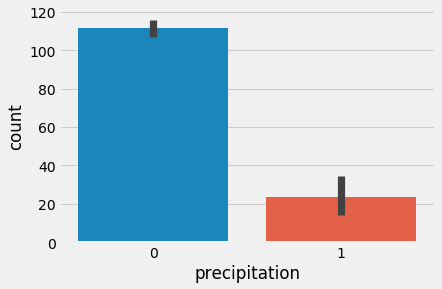

In [ ]:
sns.barplot(x="precipitation", y="count",data=train)

windspeed랑 count의 상관관계를 보여주는 시각화를 하고싶었는데.. 

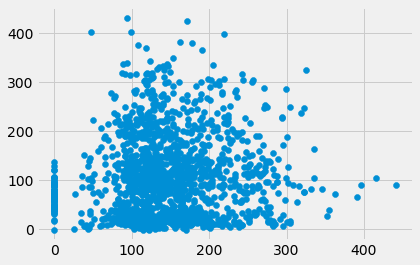

In [ ]:
plt.scatter(train['total_polution'],train['count'])

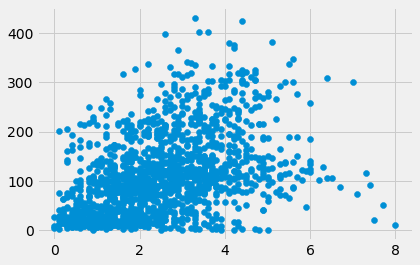

In [ ]:
plt.scatter(train['windspeed'],train['count'])


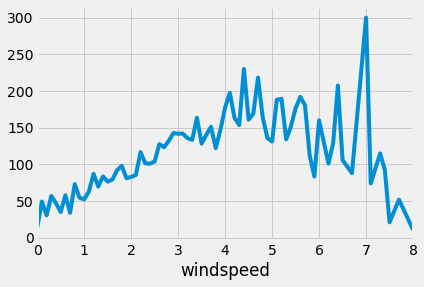

In [ ]:
train.groupby('windspeed')['count'].mean().plot()

In [11]:
train.head()

,id,datetime,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count,hour,weekday,day
0,0,2017-04-01 00:00:00,4.9,0,1.5,81,2000,-1.000,-1.0,-1.0,39.0,0,5,1
1,1,2017-04-01 01:00:00,5.1,0,1.3,77,2000,0.018,16.0,-1.0,34.0,1,5,1
2,2,2017-04-01 02:00:00,5.7,0,0.8,74,2000,0.032,12.0,13.0,29.0,2,5,1
3,3,2017-04-01 03:00:00,5.7,0,0.6,77,1960,0.028,14.0,18.0,21.0,3,5,1
4,4,2017-04-01 04:00:00,5.5,0,0.5,78,2000,0.022,18.0,-1.0,6.0,4,5,1


In [12]:
train['ozone'] = train['ozone'].fillna(-1)
train['pm10'] = train['pm10'].fillna(-1)
train['pm2.5'] = train['pm2.5'].fillna(-1)
train['windspeed'] =train['windspeed'].fillna(-1)
train['count'] =train['count'].fillna(-1)

test['ozone'] = test['ozone'].fillna(-1)
test['pm10'] = test['pm10'].fillna( -1 )
test['pm2.5'] = test['pm2.5'].fillna( -1 )
test['windspeed'] =test['windspeed'].fillna(-1)

In [13]:
input_var=['temperature', 'precipitation', 'windspeed', 'humidity','visibility' ,
           'ozone','pm10' ,'pm2.5' , 'weekday']

target='count'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth=6,n_estimators=1000,max_features=10)
rf.fit(train[input_var].fillna(0),train[target])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
prediction_rf=rf.predict_proba(test[input_var].fillna(0))[:,1]
import xgboost as xgb
xgb_param={'objective':'reg:linear',
          'metric':'rmse',
          'max_depth':6,
          'eta':0.02,
          'min_child_samples':100
          }

In [ ]:
from sklearn.model_selection import KFold
folds =KFold(n_splits=5,shuffle=True)

In [ ]:
folds=KFold(n_splits=5,shuffle=True)

In [ ]:
oof_rf=np.zeros(len(train))

prediction_rf=np.zeros(len(test))

for fold_, (trn_idx,val_idx) in enumerate(folds.split(train[input_var].values,train[target].values)):
  
  rf.fit(train[input_var].iloc[trn_idx].fillna(0),train[target].iloc[trn_idx])
  
  oof_rf[val_idx]=rf.predict_proba(train[input_var].fillna(0).iloc[val_idx])[:,1]
  
  prediction_rf+=rf.predict_proba(test[input_var].fillna(0))[:,1]

prediction_rf=prediction_rf/5

In [ ]:
oof_xgb=np.zeros(len(train))

prediction_xgb=np.zeros(len(test))

for fold_, (trn_idx,val_idx) in enumerate(folds.split(train[input_var].values,train[target].values)):
  trn_data=xgb.DMatrix(train[input_var].iloc[trn_idx],train[target].iloc[trn_idx])
  val_data=xgb.DMatrix(train[input_var].iloc[val_idx],train[target].iloc[val_idx])
  
  num_tree=10000
  
  xgb_model=xgb.train(xgb_param,
                     trn_data,
                     num_tree,
                     [(trn_data,'train'),(val_data,'valid')],verbose_eval=0,
                     early_stopping_rounds=100)
  
  oof_xgb[val_idx]=xgb_model.predict(xgb.DMatrix(train[input_var].iloc[val_idx]),ntree_limit=xgb_model.best_ntree_limit)
  
  prediction_xgb+=xgb_model.predict(xgb.DMatrix(test[input_var]),ntree_limit=xgb_model.best_ntree_limit)
  
prediction_xgb=prediction_xgb/5

In [ ]:
train_super=pd.DataFrame({'oof_rf':oof_rf,'oof_xgb':oof_xgb,'count':train['count']})
test_super=pd.DataFrame({'pred_rf':prediction_rf,'pred_xgb':prediction_xgb})

In [ ]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(train_super[['oof_rf','oof_xgb']],train_super['count'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [ ]:
final_predictions=lr.predict(test_super[['pred_rf','pred_xgb']])

In [ ]:
pd.DataFrame({'id':test['id'],'count':final_predictions}).to_csv("submission_34.csv")